In [2]:
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-tf-plugin-cuda110

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.6/382.6 MB 7.5 MB/s eta 0:00:0000:0100:01
  Created wheel for nvidia-dali-tf-plugin-cuda110: filename=nvidia_dali_tf_plugin_cuda110-1.19.0-cp310-cp310-linux_x86_64.whl size=126645 sha256=9b5f9821e9773f74ae331fd5dfc7a6fd83b6f0246d72050a6932d720ffd5a01a
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/94/db/3f64718315f5ae7fde45f178a208625ed858c0490201dc5ca2
Successfully built nvidia-dali-tf-plugin-cuda110


In [23]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.types as types
import nvidia.dali.fn as fn
import nvidia.dali.math as math
import numpy as np
from time import time
import os.path

import random
random.seed(1231231)   # Random is used to pick colors

test_data_root = "/home/jovyan/work/data"
file_root = test_data_root = "/home/jovyan/work/data/"
annotations_file = os.path.join(test_data_root, 'leaves-coco-verified.json')

num_gpus = 1     # Single GPU for this example
device_id = 0
batch_size = 32
num_threads = 4  # Number of CPU threads

In [25]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id)
with pipe:
    inputs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=file_root,
        annotations_file=annotations_file,
        polygon_masks=True, # Load segmentation mask data as polygons
        ltrb=True,          # Bounding boxes to be expressed as left, top, right, bottom coordinates
    )
    images = fn.decoders.image(inputs, device='mixed')
    pipe.set_outputs(images, bboxes, labels, polygons, vertices)
pipe.build()

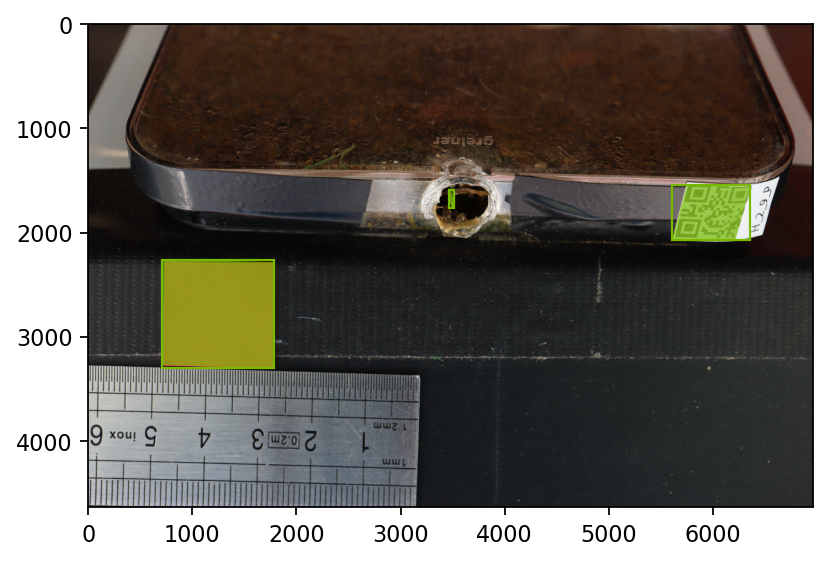

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_coco_sample(image, bboxes, labels, mask_polygons, mask_vertices, relative_coords=False):
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(dpi=160)

    # Displaying the image
    ax.imshow(image)

    # Bounding boxes
    for bbox, label in zip(bboxes, labels):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax.add_patch(rect)

    # Segmentation masks
    for polygon in mask_polygons:
        mask_idx, start_vertex, end_vertex = polygon
        polygon_vertices = mask_vertices[start_vertex:end_vertex]  # Select polygon vertices
        # Scale relative coordinates to the image dimensions, if necessary
        polygon_vertices = polygon_vertices * [W, H] if relative_coords else polygon_vertices
        poly = patches.Polygon(polygon_vertices, True, facecolor='#76b900', alpha=0.7)
        ax.add_patch(poly)

    plt.show()

def show(outputs, relative_coords=False):
    i = 16  # Picked a sample idx that shows more than one bounding box
    images, bboxes, labels, mask_polygons, mask_vertices = outputs
    plot_coco_sample(images.as_cpu().at(i), bboxes.at(i), labels.at(i),
                     mask_polygons.at(i), mask_vertices.at(i),
                     relative_coords=relative_coords)

outputs = pipe.run()
show(outputs)

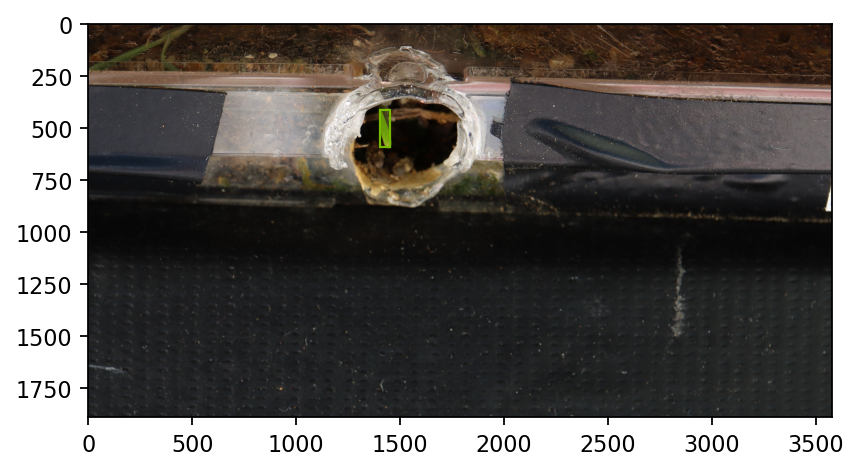

In [27]:
# Wrapping the pipeline definition in separate functions that we can reuse later

def coco_reader_def():
    inputs, bboxes, labels, polygons, vertices = fn.readers.coco(
        file_root=file_root,
        annotations_file=annotations_file,
        polygon_masks=True, # Load segmentation mask data as polygons
        ratio=True,         # Bounding box and mask polygons to be expressed in relative coordinates
        ltrb=True,          # Bounding boxes to be expressed as left, top, right, bottom coordinates
    )
    return inputs, bboxes, labels, polygons, vertices

def random_bbox_crop_def(bboxes, labels, polygons, vertices):
    # RandomBBoxCrop works with relative coordinates
    # The arguments have been selected to produce a significantly visible crop
    # To learn about all the available options, see the documentation
    anchor_rel, shape_rel, bboxes, labels, bbox_indices = fn.random_bbox_crop(
        bboxes,
        labels,
        aspect_ratio=[0.5, 2],     # Range of aspect ratios
        thresholds=[0.0],          # No minimum intersection-over-union, for demo purposes
        allow_no_crop=False,       # No-crop is disallowed, for demo purposes
        scaling=[0.3, 0.6],        # Scale range of the crop with respect to the image shape
        seed=12345,                # Fixed random seed for deterministic results
        bbox_layout="xyXY",        # left, top, right, back
        output_bbox_indices=True,  # Output indices of the filtered bounding boxes
    )

    # Select mask polygons of those bounding boxes that remained in the image
    polygons, vertices = fn.segmentation.select_masks(
        bbox_indices, polygons, vertices
    )

    return anchor_rel, shape_rel, bboxes, labels, polygons, vertices

pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id)
with pipe:
    inputs, bboxes, labels, polygons, vertices = coco_reader_def()
    anchor_rel, shape_rel, bboxes, labels, polygons, vertices = \
        random_bbox_crop_def(bboxes, labels, polygons, vertices)

    # Partial decoding of the image
    images = fn.decoders.image_slice(
        inputs, anchor_rel, shape_rel, normalized_anchor=True, normalized_shape=True, device='cpu'
    )
    # Cropped image dimensions
    crop_shape = fn.shapes(images, dtype=types.FLOAT)
    crop_h = fn.slice(crop_shape, 0, 1, axes=[0])
    crop_w = fn.slice(crop_shape, 1, 1, axes=[0])

    images = images.gpu()

    # Adjust masks coordinates to the coordinate space of the cropped image, while also converting
    # relative to absolute coordinates by mapping the top-left corner (anchor_rel_x, anchor_rel_y), to (0, 0)
    # and the bottom-right corner (anchor_rel_x+shape_rel_x, anchor_rel_y+shape_rel_y) to (crop_w, crop_h)
    MT_vertices = fn.transforms.crop(
        from_start=anchor_rel, from_end=(anchor_rel + shape_rel),
        to_start=(0.0, 0.0), to_end=fn.cat(crop_w, crop_h)
    )
    vertices = fn.coord_transform(vertices, MT=MT_vertices)

    # Convert bounding boxes to absolute coordinates
    MT_bboxes = fn.transforms.crop(
        to_start=(0.0, 0.0, 0.0, 0.0), to_end=fn.cat(crop_w, crop_h, crop_w, crop_h)
    )
    bboxes = fn.coord_transform(bboxes, MT=MT_bboxes)

    pipe.set_outputs(images, bboxes, labels, polygons, vertices)

pipe.build()
outputs = pipe.run()
show(outputs)

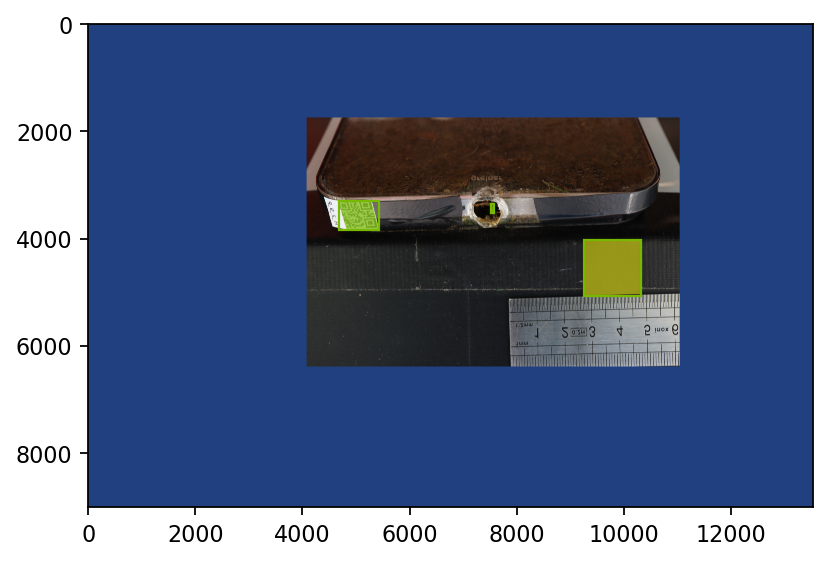

In [28]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=12345)
with pipe:
    inputs, bboxes, labels, polygons, vertices = coco_reader_def()
    orig_shape = fn.peek_image_shape(inputs)
    images = fn.decoders.image(inputs)
    images = images.gpu()
    px = fn.random.uniform(range=(0, 1))
    py = fn.random.uniform(range=(0, 1))
    ratio = fn.random.uniform(range=(1, 2))
    images = fn.paste(images, paste_x=px, paste_y=py, ratio=ratio, fill_value=(32, 64, 128))
    bboxes = fn.bbox_paste(bboxes, paste_x=px, paste_y=py, ratio=ratio, ltrb=True)

    scale = 1.0 / ratio
    margin = ratio - 1.0
    px_1 = scale * px * margin
    py_1 = scale * py * margin
    ver_x = scale * fn.slice(vertices, 0, 1, axes=[1]) + px_1
    ver_y = scale * fn.slice(vertices, 1, 1, axes=[1]) + py_1
    vertices = fn.cat(ver_x, ver_y, axis=1)

    should_flip = fn.random.coin_flip(probability=1.0)  # 100% probability for demo purposes
    images = fn.flip(images, horizontal=should_flip)
    bboxes = fn.bb_flip(bboxes, horizontal=should_flip, ltrb=True)
    vertices = fn.coord_flip(vertices, flip_x=should_flip)

    pipe.set_outputs(images, bboxes, labels, polygons, vertices)

pipe.build()
outputs = pipe.run()
show(outputs, relative_coords=True)